In [1]:
import torch
import json, os
import bertviz, uuid
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from collections import Counter
from transformers import LlamaForCausalLM, LlamaTokenizer
from IPython.core.display import display, HTML, Javascript
from bertviz.util import format_special_chars, format_attention, num_layers, num_heads
LAYER_NUM = 32
HEAD_NUM = 32
HEAD_DIM = 128
HIDDEN_DIM = HEAD_NUM * HEAD_DIM
torch.set_default_device("cuda")

/tmp/5197255.1.nvidiagpu.q/ipykernel_30045/1940179048.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Javascript


In [2]:
def transfer_output(model_output):
    all_pos_layer_input = []
    all_pos_attn_output = []
    all_pos_residual_output = []
    all_pos_ffn_output = []
    all_pos_layer_output = []
    all_last_attn_subvalues = []
    all_pos_coefficient_scores = []
    all_attn_scores = []
    for layer_i in range(LAYER_NUM):
        cur_layer_input = model_output[layer_i][0]
        cur_attn_output = model_output[layer_i][1]
        cur_residual_output = model_output[layer_i][2]
        cur_ffn_output = model_output[layer_i][3]
        cur_layer_output = model_output[layer_i][4]
        cur_last_attn_subvalues = model_output[layer_i][5]
        cur_coefficient_scores = model_output[layer_i][6]
        cur_attn_weights = model_output[layer_i][7]
        all_pos_layer_input.append(cur_layer_input[0].tolist())
        all_pos_attn_output.append(cur_attn_output[0].tolist())
        all_pos_residual_output.append(cur_residual_output[0].tolist())
        all_pos_ffn_output.append(cur_ffn_output[0].tolist())
        all_pos_layer_output.append(cur_layer_output[0].tolist())
        all_last_attn_subvalues.append(cur_last_attn_subvalues[0].tolist())
        all_pos_coefficient_scores.append(cur_coefficient_scores[0].tolist())
        all_attn_scores.append(cur_attn_weights)
    return all_pos_layer_input, all_pos_attn_output, all_pos_residual_output, all_pos_ffn_output, \
           all_pos_layer_output, all_last_attn_subvalues, all_pos_coefficient_scores, all_attn_scores
def get_fc2_params(model, layer_num):
    return model.model.layers[layer_num].mlp.down_proj.weight.data
def get_bsvalues(vector, model, final_var):
    vector = vector * torch.rsqrt(final_var + 1e-6)
    vector_rmsn = vector * model.model.norm.weight.data
    vector_bsvalues = model.lm_head(vector_rmsn).data
    return vector_bsvalues
def get_prob(vector):
    prob = torch.nn.Softmax(-1)(vector)
    return prob
def transfer_l(l):
    new_x, new_y = [], []
    for x in l:
        new_x.append(x[0])
        new_y.append(x[1])
    return new_x, new_y
def plt_bar(x, y, yname="log increase"):
    x_major_locator=MultipleLocator(1)
    plt.figure(figsize=(8, 3))
    ax=plt.gca()
    ax.xaxis.set_major_locator(x_major_locator)
    plt_x = [a/2 for a in x]
    plt.xlim(-0.5, plt_x[-1]+0.49)
    x_attn, y_attn, x_ffn, y_ffn = [], [], [], []
    for i in range(len(x)):
        if i%2 == 0:
            x_attn.append(x[i]/2)
            y_attn.append(y[i])
        else:
            x_ffn.append(x[i]/2)
            y_ffn.append(y[i])
    plt.bar(x_attn, y_attn, color="darksalmon", label="attention layers")
    plt.bar(x_ffn, y_ffn, color="lightseagreen", label="FFN layers")
    plt.xlabel("layer")
    plt.ylabel(yname)
    plt.legend()
    plt.show()
def plt_heatmap(data):
    xLabel = range(len(data[0]))
    yLabel = range(len(data))
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.set_xticks(range(len(xLabel)))
    ax.set_xticklabels(xLabel)
    ax.set_yticks(range(len(yLabel)))
    ax.set_yticklabels(yLabel)
    im = ax.imshow(data, cmap=plt.cm.hot_r)
    #plt.colorbar(im)
    plt.title("attn head log increase heatmap")
    plt.show()

In [3]:
#please replace your own dir saving llama-7b model.
#if you haven't downloaded it, you can try "huggyllama/llama-7b" to automatically download it from huggingface.
modelname = "../../scratch/save_models/llama-7b"
tokenizer = LlamaTokenizer.from_pretrained(modelname)
model = LlamaForCausalLM.from_pretrained(modelname)
model.eval()
model.cuda()

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
 

In [4]:
#compute the final prediction of the input
test_sentence = "love : bar like: bar eight : foo two : foo one :"
indexed_tokens = tokenizer.encode(test_sentence)
tokens = [tokenizer.decode(x) for x in indexed_tokens]
tokens_tensor = torch.tensor([indexed_tokens])
with torch.no_grad():
    outputs = model(tokens_tensor)
    predictions = outputs[0]
predicted_top10 = torch.argsort(predictions[0][-1], descending=True)[:10]
predicted_text = [tokenizer.decode(x) for x in predicted_top10]
print(test_sentence, "=>", predicted_text)
all_pos_layer_input, all_pos_attn_output, all_pos_residual_output, all_pos_ffn_output, all_pos_layer_output, \
all_last_attn_subvalues, all_pos_coefficient_scores, all_attn_scores = transfer_output(outputs[1])
final_var = torch.tensor(all_pos_layer_output[-1][-1]).pow(2).mean(-1, keepdim=True)
pos_len = len(tokens)
print(tokens)

love : bar like: bar eight : foo two : foo one : => ['foo', 'bar', 'two', 'fo', 'one', 'love', 'three', '', 'four', 'five']
['<s>', 'love', ':', 'bar', 'like', ':', 'bar', 'eight', ':', 'foo', 'two', ':', 'foo', 'one', ':']


In [5]:
predict_index = predicted_top10[0].item()
print(predict_index, tokenizer.decode(predict_index))

7953 foo


attn sum:  7.465999999999998 ffn sum:  2.133
attn:  [('23', 1.991), ('21', 1.989), ('28', 0.563), ('18', 0.507), ('26', 0.462), ('20', 0.43), ('31', 0.409), ('19', 0.305), ('15', 0.188), ('17', 0.174), ('16', 0.139), ('13', 0.088), ('22', 0.08), ('14', 0.077), ('30', 0.069), ('29', 0.068), ('27', 0.062), ('5', 0.039), ('12', 0.032), ('9', 0.03), ('7', 0.027), ('0', 0.012), ('10', 0.009), ('3', 0.008), ('1', -0.003), ('4', -0.003), ('8', -0.003), ('6', -0.008), ('2', -0.011), ('11', -0.011), ('24', -0.106), ('25', -0.147)]
ffn:  [('31', 1.111), ('21', 0.235), ('29', 0.121), ('26', 0.117), ('24', 0.101), ('28', 0.101), ('27', 0.097), ('19', 0.095), ('25', 0.084), ('16', 0.071), ('14', 0.065), ('20', 0.063), ('15', 0.058), ('18', 0.051), ('17', 0.046), ('8', 0.043), ('10', 0.032), ('13', 0.032), ('22', 0.02), ('0', 0.006), ('2', 0.005), ('3', 0.003), ('1', -0.006), ('4', -0.009), ('6', -0.015), ('30', -0.015), ('9', -0.015), ('11', -0.025), ('5', -0.038), ('12', -0.048), ('7', -0.057), ('

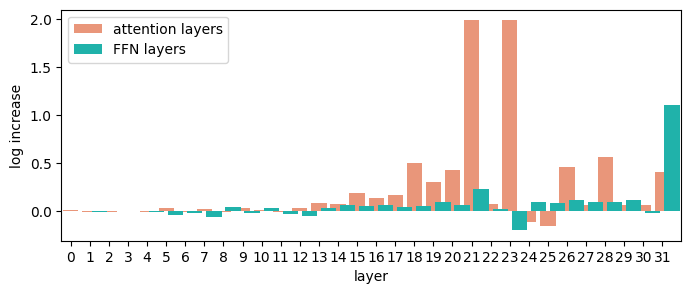

In [6]:
#layer-level increase: most increase happens in attention layers
all_attn_log_increase = []
for layer_i in range(LAYER_NUM):
    cur_attn_vector = torch.tensor(all_pos_attn_output[layer_i][-1])
    cur_layer_input = torch.tensor(all_pos_layer_input[layer_i][-1])
    origin_prob_log = torch.log(get_prob(get_bsvalues(cur_layer_input, model, final_var))[predict_index])
    cur_attn_vector_plus = cur_attn_vector + cur_layer_input
    cur_attn_vector_bsvalues = get_bsvalues(cur_attn_vector_plus, model, final_var)
    cur_attn_vector_probs = get_prob(cur_attn_vector_bsvalues)
    cur_attn_vector_probs = cur_attn_vector_probs[predict_index]
    cur_attn_vector_probs_log = torch.log(cur_attn_vector_probs)
    cur_attn_vector_probs_log_increase = cur_attn_vector_probs_log - origin_prob_log
    all_attn_log_increase.append(cur_attn_vector_probs_log_increase.item())
all_ffn_log_increase = []
for layer_i in range(LAYER_NUM):
    cur_ffn_vector = torch.tensor(all_pos_ffn_output[layer_i][-1])
    cur_residual = torch.tensor(all_pos_residual_output[layer_i][-1])
    origin_prob_log = torch.log(get_prob(get_bsvalues(cur_residual, model, final_var))[predict_index])
    cur_ffn_vector_plus = cur_ffn_vector + cur_residual
    cur_ffn_vector_bsvalues = get_bsvalues(cur_ffn_vector_plus, model, final_var)
    cur_ffn_vector_probs = get_prob(cur_ffn_vector_bsvalues)
    cur_ffn_vector_probs = cur_ffn_vector_probs[predict_index]
    cur_ffn_vector_probs_log = torch.log(cur_ffn_vector_probs)
    cur_ffn_vector_probs_log_increase = cur_ffn_vector_probs_log - origin_prob_log
    all_ffn_log_increase.append(cur_ffn_vector_probs_log_increase.tolist())
attn_list, ffn_list = [], []
for layer_i in range(LAYER_NUM):
    attn_list.append([str(layer_i), all_attn_log_increase[layer_i]])
    ffn_list.append([str(layer_i), all_ffn_log_increase[layer_i]])
attn_list_sort = sorted(attn_list, key=lambda x: x[-1])[::-1]#[:10]
ffn_list_sort = sorted(ffn_list, key=lambda x: x[-1])[::-1]#[:10]
attn_increase_compute, ffn_increase_compute = [], []
for indx, increase in attn_list_sort:
    attn_increase_compute.append((indx, round(increase, 3)))
for indx, increase in ffn_list_sort:
    ffn_increase_compute.append((indx, round(increase, 3)))
print("attn sum: ", sum([x[1] for x in attn_increase_compute]), 
      "ffn sum: ", sum([x[1] for x in ffn_increase_compute]))
print("attn: ", attn_increase_compute)
print("ffn: ", ffn_increase_compute)
all_increases_draw = []
for i in range(len(attn_list)):
    all_increases_draw.append(attn_list[i][1])
    all_increases_draw.append(ffn_list[i][1])    
plt_bar(range(len(all_increases_draw)), all_increases_draw)

[['23_19', 1.7134], ['21_23', 1.1438], ['28_17', 0.5421], ['26_20', 0.3981], ['20_31', 0.3502], ['21_12', 0.3018], ['18_8', 0.2831], ['21_3', 0.2454], ['21_25', 0.1783], ['24_5', 0.1629], ['31_25', 0.1538], ['19_5', 0.1325], ['17_6', 0.1322], ['31_20', 0.1282], ['23_5', 0.1262], ['25_25', 0.121], ['23_27', 0.1157], ['31_6', 0.1012], ['19_30', 0.0977], ['29_22', 0.0696], ['28_16', 0.0685], ['19_14', 0.0639], ['29_7', 0.0608], ['20_27', 0.0603], ['21_27', 0.0598], ['21_4', 0.0593], ['15_17', 0.0589], ['18_10', 0.0562], ['15_18', 0.0548], ['17_15', 0.0538]]


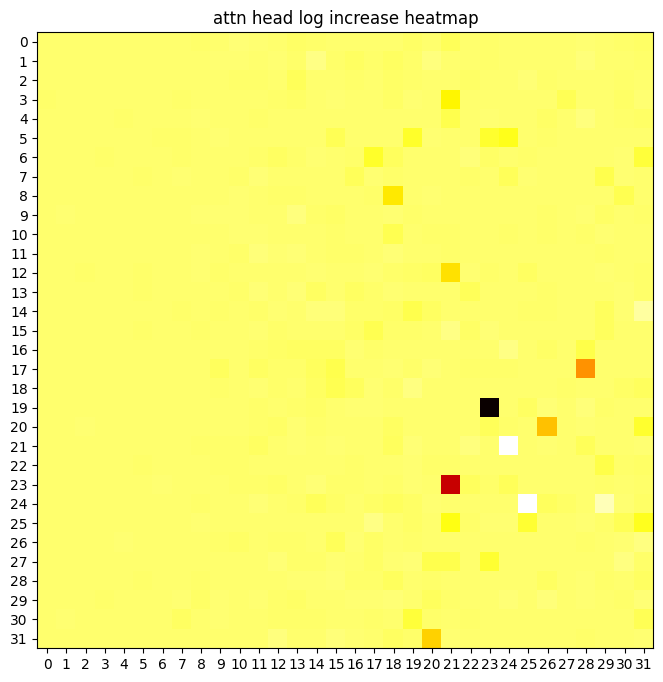

In [7]:
#head-level increase
all_head_increase = []
for test_layer in range(LAYER_NUM):
    cur_layer_input = torch.tensor(all_pos_layer_input[test_layer])
    cur_v_heads = torch.tensor(all_last_attn_subvalues[test_layer])
    cur_attn_o_split = model.model.layers[test_layer].self_attn.o_proj.weight.data.T.view(HEAD_NUM, HEAD_DIM, -1)
    cur_attn_subvalues_headrecompute = torch.bmm(cur_v_heads, cur_attn_o_split).permute(1, 0, 2)
    cur_attn_subvalues_head_sum = torch.sum(cur_attn_subvalues_headrecompute, 0)
    cur_layer_input_last = cur_layer_input[-1]
    origin_prob = torch.log(get_prob(get_bsvalues(cur_layer_input_last, model, final_var))[predict_index])
    cur_attn_subvalues_head_plus = cur_attn_subvalues_head_sum + cur_layer_input_last
    cur_attn_plus_probs = torch.log(get_prob(get_bsvalues(
            cur_attn_subvalues_head_plus, model, final_var))[:, predict_index])
    cur_attn_plus_probs_increase = cur_attn_plus_probs - origin_prob
    for i in range(len(cur_attn_plus_probs_increase)):
        all_head_increase.append([str(test_layer)+"_"+str(i), round(cur_attn_plus_probs_increase[i].item(), 4)])

all_head_increase_sort = sorted(all_head_increase, key=lambda x:x[-1])[::-1]
print(all_head_increase_sort[:30])
all_head_increase_list = [x[1] for x in all_head_increase]
all_head_increase_list_split = torch.tensor(all_head_increase_list).view((LAYER_NUM, HEAD_NUM)).permute((1,0)).tolist()
plt_heatmap(all_head_increase_list_split)

In [8]:
#pos-level increase in a specified head
test_layer, test_head = 19, 5
cur_layer_input = torch.tensor(all_pos_layer_input[test_layer])
cur_v_heads = torch.tensor(all_last_attn_subvalues[test_layer])
cur_attn_o_split = model.model.layers[test_layer].self_attn.o_proj.weight.data.T.view(HEAD_NUM, HEAD_DIM, -1)
cur_attn_subvalues_headrecompute = torch.bmm(cur_v_heads, cur_attn_o_split).permute(1, 0, 2)
cur_attn_subvalues_headrecompute_curhead = cur_attn_subvalues_headrecompute[:, test_head, :]
cur_layer_input_last = cur_layer_input[-1]
origin_prob = torch.log(get_prob(get_bsvalues(cur_layer_input_last, model, final_var))[predict_index])
cur_attn_subvalues_headrecompute_curhead_plus = cur_attn_subvalues_headrecompute_curhead + cur_layer_input_last
cur_attn_subvalues_headrecompute_curhead_plus_probs = torch.log(get_prob(get_bsvalues(
    cur_attn_subvalues_headrecompute_curhead_plus, model, final_var))[:, predict_index])
cur_attn_subvalues_headrecompute_increase = cur_attn_subvalues_headrecompute_curhead_plus_probs - origin_prob
cur_attn_subvalues_headrecompute_increase_zip = list(zip(range(len(cur_attn_subvalues_headrecompute_increase)), 
    tokens, cur_attn_subvalues_headrecompute_increase.tolist()))
cur_attn_subvalues_headrecompute_increase_zip_sort = sorted(cur_attn_subvalues_headrecompute_increase_zip,
    key=lambda x:x[-1])[::-1]
cur_layer_input_bsvalues = get_bsvalues(cur_layer_input, model, final_var)
cur_layer_input_bsvalues_sort = torch.argsort(cur_layer_input_bsvalues, descending=True)
cur_attn_subvalues_headrecompute_curhead_bsvalues = get_bsvalues(
    cur_attn_subvalues_headrecompute_curhead, model, final_var)
cur_attn_subvalues_headrecompute_curhead_bsvalues_sort = torch.argsort(
    cur_attn_subvalues_headrecompute_curhead_bsvalues, descending=True)
key_input = cur_layer_input.clone()
key_input -= torch.tensor(all_pos_layer_input[0])
for layer_i in range(test_layer):
    key_input -= torch.tensor(all_pos_ffn_output[layer_i])
key_input_bsvalues = get_bsvalues(key_input, model, final_var)
key_input_bsvalues_sort = torch.argsort(key_input_bsvalues, descending=True)
print(list(zip(range(len(tokens)), tokens)))
for pos, word, increase in cur_attn_subvalues_headrecompute_increase_zip_sort:
    print("\n", pos, word, "increase: ", round(increase, 4), "attn: ", round(
        all_attn_scores[test_layer][0][test_head][-1][pos].item(), 4))
    print("layer input: ", [tokenizer.decode(x) for x in cur_layer_input_bsvalues_sort[pos][:20]])
    print("key: ", [tokenizer.decode(x) for x in key_input_bsvalues_sort[pos][:20]])
    print("value: ", [tokenizer.decode(x) for x in cur_attn_subvalues_headrecompute_curhead_bsvalues_sort[pos][:10]])

[(0, '<s>'), (1, 'love'), (2, ':'), (3, 'bar'), (4, 'like'), (5, ':'), (6, 'bar'), (7, 'eight'), (8, ':'), (9, 'foo'), (10, 'two'), (11, ':'), (12, 'foo'), (13, 'one'), (14, ':')]

 9 foo increase:  0.1122 attn:  0.6032
layer input:  ['led', 'bar', 'Foo', 'Bar', 'Bar', 'bars', 'ze', 'zy', 'foo', 'ble', 'like', 'ber', 'Foo', 'obar', 'ish', 'za', 'LED', 'ist', 'alt', 'solid']
key:  ['like', 'bar', 'bars', 'bar', 'Foo', 'bars', 'Like', 'oo', 'Bar', 'o', 'Bar', 'love', 'neutral', 'Pho', 'club', 'brow', 'foo', 'rock', 'ville', 'ordered']
value:  ['bar', 'Bar', 'bar', 'Bar', 'Бар', 'bars', 'bars', 'бар', 'baron', 'overline']

 3 bar increase:  0.0085 attn:  0.0219
layer input:  ['rel', 'bec', 'riers', 'ista', 'code', 'rier', 'bar', 'bour', 'bara', 'eness', 'ge', 'ometer', 'ley', 'ney', 'codes', 'none', 'tered', 'rett', 'red', 'ren']
key:  ['love', 'Love', ':', 'LO', '::', '|', '♥', '<0x0A>', 'lo', '>', 'x', 'court', '?', 'vs', '-', 'Une', '/', 'my', 'Cher', 'bou']
value:  ['bar', 'Bar', 'bar

In [9]:
#visualize the information transform by attention weights
n_heads = num_heads(all_attn_scores)
attn_data = []
include_layers = list(range(num_layers(all_attn_scores)))
include_heads = list(range(n_heads))
attention1 = format_attention(all_attn_scores, None)
attn_data.append({'name': None, 'attn': attention1.tolist(), 'left_text': tokens, 'right_text': tokens})
vis_id = 'bertviz-%s'%(uuid.uuid4().hex)
select_html = ""
vis_html = f"""      
        <div id="{vis_id}" style="font-family:'Helvetica Neue', Helvetica, Arial, sans-serif;">
            <span style="user-select:none">
                Layer: <select id="layer"></select>
                {select_html}
            </span>
            <div id='vis'></div>
        </div>
    """
if True:
    for d in attn_data:
        attn_seq_len_left = len(d['attn'][0][0]) #16
        attn_seq_len_right = len(d['attn'][0][0][0]) #16
        d['left_text'] = format_special_chars(d['left_text'])
        d['right_text'] = format_special_chars(d['right_text'])
params = {
        'attention': attn_data,
        'default_filter': "0",
        'root_div_id': vis_id,
        'layer': None,
        'heads': None,
        'include_layers': include_layers
        }
display(HTML('<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js"></script>'))
display(HTML(vis_html))
__location__ = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(bertviz.__file__)))
vis_js = open(os.path.join(__location__, 'head_view.js')).read().replace("PYTHON_PARAMS", json.dumps(params))
display(Javascript(vis_js))

<IPython.core.display.Javascript object>